# **02 Precept**

# **Agenda**
Topis covered

*   Matrix Multiplication (written)
*   Ballistics Example (written/coding)
*   LU Decomposition and Matrix Inverse (coding)
*   More plotting (coding)

# Ballistics

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as la
from scipy.linalg import lu_factor
import time

def construct_A_b(h, eta, m, g):
    A = np.zeros((4, 4))
    A[0,0] = 1
    A[1,1] = 1
    A[0,2] = h
    A[1,3] = h
    A[2,2] = 1 - h*eta/m
    A[3,3] = 1 - h*eta/m

    b = np.zeros(4)
    b[2] = 0
    b[3] = g*h
    return A, b

def plot_trajectories(v0, T, A, b, title):
    # v0 is the initial velocity
    # eta is the drag coefficient
    # T is the horizon length
    # h is the time length of each increment
    # g is the gravitational force 9.8
    # m is the mass

    # setup the initial state
    init_state = np.zeros(4)
    init_state[2:] = v0

    # retrieve A, b 
    A, b = construct_A_b(h, eta, m, g)

    # simulate the dynamics
    state_trajectory = np.zeros((T, 4))
    state_trajectory[0,:] = init_state
    for i in range(1, T):
        state_trajectory[i,:] = A @ state_trajectory[i-1,:] + b

    # plot the trajectory
    plt.plot(state_trajectory[:,0], state_trajectory[:,1])
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


def find_C_d(A, b, eta, T, h, g, m):
    # pT is the desired final position
    # eta is the drag coefficient
    # T is the horizon length
    # h is the time length of each increment
    # g is the gravitational force 9.8
    # m is the mass
    p0 = np.zeros(2)
    F = np.linalg.matrix_power(A, T)
    C = F[:2,2:]

    # j = (A^(T-1) + ... + A + I)b
    Asum = np.identity(4)
    for i in range(T):
        Asum = Asum + np.linalg.matrix_power(A, i)
    j = Asum @ b
    d = F[:2,:2] @ p0 + j[:2]

    return C, d



In [9]:
def forward_substitution(L, b):
    n = L.shape[0]
    x = np.zeros(n)
    for i in range(n):
        x[i] = (b[i] - L[i,:i] @ x[:i])/L[i, i]
    return x

def backward_substitution(U, b):
    n = U.shape[0]
    x = np.zeros(n)
    for i in reversed(range(n)):
        x[i] = (b[i] - U[i,i+1:] @ x[i+1:])/U[i, i]
    return x
 

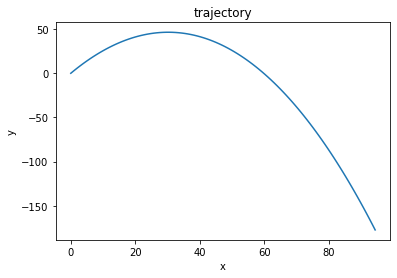

In [10]:
# simulate a trajectory
v0 = np.array([10,30])
eta = .05
h = .1
T = 100
g = -9.8
m = 5
A, b = construct_A_b(h, eta, m, g)
plot_trajectories(v0, T, A, b, 'trajectory')

In [11]:
# find the desired initial velocity
# we have a system of type C v_0 = p_T - d
C, d = find_C_d(A, b, eta, T, h, g, m)
P,L,U = la.lu(C)


np.linalg.solve time 0.0001900196075439453
LU time 0.00022029876708984375


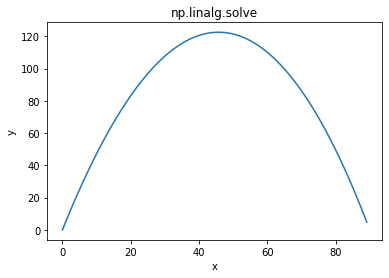

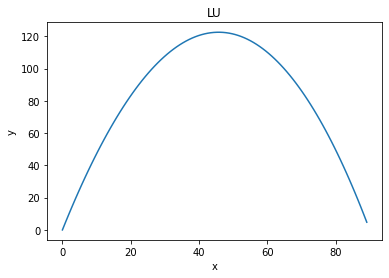

In [12]:
# np.linalg.solve
pT = np.array([90, 0])
t0 = time.time()
v0 = np.linalg.solve(C, pT - d)
t1 = time.time()
print('np.linalg.solve time', t1 - t0)

# lu factorization
tt0 = time.time()
permCols = P.T @ (pT - d)
x = forward_substitution(L,permCols)
v0_lu = backward_substitution(U, x)
tt1 = time.time()
print('LU time', tt1 - tt0)

plot_trajectories(v0, T, A, b, 'np.linalg.solve')
plot_trajectories(v0_lu, T, A, b, 'LU')

# **LU and Matrix Inverse**

We learn in lecture that we can factorize a square matrix into lower and upper triangular matrices and that using this **LU decomposition** of a matrix $A$ to solve a linear system $Ax = b$ is often faster than computing the inverse and solving it directly, i.e. $A^{-1}b = x$. In this exercise, we show that it is relatively easy/cheap to compute $A^{-1}$ once we have the lower and upper triangular matrices $L$ and $U$ respectively. 

(Written Portion)



In [129]:
n = 10
A = np.random.normal(size=[n,n])

A = A.T@A    
I = np.eye(n)

lu, piv = lu_factor(A)
print('piv', piv)
L, U = np.tril(lu, k=-1) + np.eye(n), np.triu(lu)
piv_indices = [i for i in range(n)]

for i in range(n):
    # swap piv_indices[i] with piv_indices[piv[i]]
    temp = piv_indices[i]
    piv_indices[i] = piv_indices[piv[i]]
    piv_indices[piv[i]] = temp
print('piv_indices', piv_indices)


piv [0 1 2 3 4 5 6 7 8 9]
piv_indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [131]:
# invert the permutation
piv_indices_inv = np.zeros(n, dtype=np.int32)
for i in np.arange(len(piv_indices)):
    piv_indices_inv[piv_indices[i]] = i
print('piv_indices_inv', piv_indices_inv)
A_inv_LU = np.zeros([n,n])
for i in range(n):
    # following line also works - get the ith col of P.T (note P.T == P^-1)
    #permCols = P.T@I[:,i]
    
    # we can get the ith col of P.T in the following way without doing any flops
    permCols = I[piv_indices_inv[i],:]

    print('permcols', permCols)
    x = forward_substitution(L, permCols)
    A_inv_LU[:,i] = backward_substitution(U, x)
    
Ainv = np.linalg.inv(A)

print('Check: residuals', Ainv - A_inv_LU)
print('Check: norm', np.linalg.norm(Ainv - A_inv_LU))

piv_indices_inv [0 1 2 3 4 5 6 7 8 9]
permcols [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
permcols [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
permcols [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
permcols [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
permcols [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
permcols [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
permcols [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
permcols [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
permcols [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
permcols [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Check: residuals [[ 2.66453526e-14 -3.37507799e-14 -6.88338275e-15  1.85094995e-15
  -3.10862447e-14 -1.05471187e-14 -2.46469511e-14  1.05471187e-14
  -2.47024623e-15 -5.01820807e-14]
 [-3.37507799e-14  4.35207426e-14  8.77076189e-15 -2.24820162e-15
   3.95239397e-14  1.39888101e-14  3.06421555e-14 -1.26565425e-14
   3.21964677e-15  6.48370246e-14]
 [-7.10542736e-15  9.32587341e-15  1.83186799e-15 -5.01335085e-16
   8.65973959e-15  2.99760217e-15  6.77236045e-15 -2.83106871e-15
   7.21644966e-16  1.35447209e-14]
 [ 2.23432384e-15 -2.35922393e-15 

# **More Plotting (Subplots, Multiple Figures)**

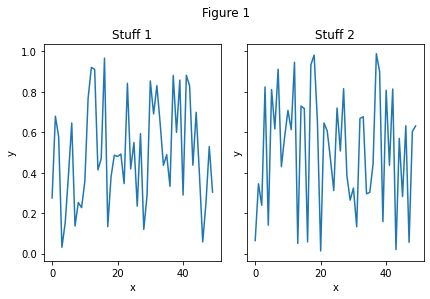

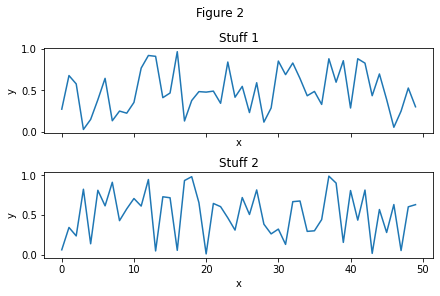

In [8]:
y = np.random.rand(50,2)
x = np.arange(50)

# Method 1
fig1, ax1 = plt.subplots(1,2, sharey=True)
fig1.tight_layout(h_pad=4)
fig1.subplots_adjust(top=0.85)
fig1.suptitle('Figure 1')
for i, ax in enumerate(ax1.flatten()):
    ax.plot(x, y[:,i])
    ax.set_title('Stuff ' + str(i+1))
    ax.set_xlabel('x')
    ax.set_ylabel('y')

# Method 2
fig2, ax2 = plt.subplots(2,1, constrained_layout=True, sharex=True)
fig2.suptitle('Figure 2')
for i, ax in enumerate(ax2.flatten()):
    ax.plot(x, y[:,i])
    ax.set_title('Stuff ' + str(i+1))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
plt.show()